# Data Analysis and Clustering

## Import the libraries

In [3]:
import json
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
from sentence_transformers import SentenceTransformer, CrossEncoder

## Dataset Description

In [4]:
data_path = 'wizard_of_wikipedia/data.json'

with open(data_path) as f:
    data = json.load(f)

In [5]:
print('Each sample in the dataset has the following keys:')
for key in data[0].keys():
    print('-', key)

Each sample in the dataset has the following keys:
- chosen_topic
- persona
- wizard_eval
- dialog
- chosen_topic_passage


In [6]:
print('Each dialog object contains a list of utterances,\nwhere each one is a dictionary with the following keys:')
for key in data[0]['dialog'][0].keys():
    print('-', key)

Each dialog object contains a list of utterances,
where each one is a dictionary with the following keys:
- speaker
- text
- checked_sentence
- checked_passage
- retrieved_passages
- retrieved_topics


In [7]:
print(f'The dataset contains {len(data)} documents.')

The dataset contains 22311 documents.


We'll reshape the data to keep in it a way that will make it easier to work with it:

In [8]:
import nltk

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

dialogues = []

for document in data:
    dialogue = {}
    dialogue['topic'] = document['chosen_topic']
    dialogue['sentences_tokenized'] = []
    dialogue['starting_speaker'] = document['dialog'][0]['speaker']
    for utterance in document['dialog']:
        tokenized = tokenizer.tokenize(utterance['text'])
        # To lower case
        tokenized = [token.lower() for token in tokenized]
        dialogue['sentences_tokenized'].append(tokenized)
    dialogues.append(dialogue)

In [9]:
print('The "dialogues" object is a list of dictionaries, \nwhere each dictionary represents a dialogue and has the following keys:')
for key in dialogues[0].keys():
    print('-', key)
print('\n"sentences_tokenized" is a list of lists, \nwhere each one represents a sentence and contains the tokens of said sentence.')

The "dialogues" object is a list of dictionaries, 
where each dictionary represents a dialogue and has the following keys:
- topic
- sentences_tokenized
- starting_speaker

"sentences_tokenized" is a list of lists, 
where each one represents a sentence and contains the tokens of said sentence.


In [10]:
avg_doc_length = sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues]) / len(dialogues)
print(f'The average document length is {avg_doc_length:.2f} sentences.')

The average document length is 9.05 sentences.


In [11]:
avg_sentence_length = sum([len(sentence) for dialogue in dialogues for sentence in dialogue['sentences_tokenized']]) / sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues])
print(f'The average sentence length is {avg_sentence_length:.2f} tokens.')

The average sentence length is 16.74 tokens.


In [12]:
avg_vocabulary_size = sum([len(set([token for sentence in dialogue['sentences_tokenized'] for token in sentence])) for dialogue in dialogues]) / len(dialogues)
print(f'The average vocabulary size is {avg_vocabulary_size:.2f} tokens.')

The average vocabulary size is 93.68 tokens.


In [13]:
dataset_vocabulary_size = len(set([token for dialogue in dialogues for sentence in dialogue['sentences_tokenized'] for token in sentence]))
print(f'The dataset vocabulary size is {dataset_vocabulary_size} tokens.')

The dataset vocabulary size is 47189 tokens.


In [14]:
n_topics = len(set([dialogue['topic'] for dialogue in dialogues]))
print(f'The dataset contains {n_topics} topics.')

The dataset contains 1365 topics.


## Create a directory for dumps

In [15]:
!mkdir dumps

mkdir: dumps: File exists


## Clustering

### Word2Vec Model

Next, we'll train a Word2Vec embedding model in order to try and cluster the documents.

In [16]:
# Train a Word2Vec model
model = Word2Vec([sentence for dialogue in dialogues for sentence in dialogue['sentences_tokenized']], min_count=1, vector_size=100, workers=4)

In [17]:
# Get the vocabulary
vocabulary = list(model.wv.key_to_index.keys())

# Get the word embeddings
word_embeddings = model.wv[vocabulary]

# Get the word embedding for a specific word
print('The word embedding for the word "computer" is:')
print(model.wv['computer'])

The word embedding for the word "computer" is:
[-1.8242408   0.60501367  0.743003    0.40092292 -0.97203326 -1.718933
 -0.36112043  0.98886144 -0.23091105 -1.1315192  -0.7171247  -0.89982355
  0.951331    0.49116445 -1.019662   -0.41335016 -0.6209953   0.03945277
  0.67864054 -0.89028805  0.38027936 -1.8109629   0.6287843  -0.21671747
 -0.2044546  -0.12265829 -0.10397498 -0.6696397   0.13339895 -0.5531605
 -0.5455801   1.2342048  -0.7061999   0.13891286 -0.03823517  0.4113422
  1.3321372   0.0508394  -0.00725377  0.01730645  0.0728      0.68044883
  0.5846627   0.04381967 -0.09208685 -0.47903568 -0.4762268  -0.09632264
 -0.06905787 -0.5390989  -0.06821793  0.9018453  -0.7523694  -0.6107601
  0.20751192  0.57247305  0.43587917  0.40770718  0.01217347  0.91098833
  2.01196    -1.2354196  -0.36956647 -0.28111163 -0.2877244  -1.3262821
 -1.453668    0.36039004  0.9676274  -0.1443109  -0.31568187  0.29688197
  1.0660677  -0.31155962  0.5355337  -0.35309812  0.37479436 -0.4404344
 -0.4224033

Since the model is trained to embed words, we'll average the weights of each dialogue's words to get a sort of 'dialogue embedding':

In [18]:
def dialogue_embed(dialogue):
    dialogue_embedding = np.zeros(100)
    for sentence in dialogue['sentences_tokenized']:
        for token in sentence:
            dialogue_embedding += model.wv[token]
    dialogue_embedding /= sum([len(sentence) for sentence in dialogue['sentences_tokenized']])
    return dialogue_embedding

dialogue_embeddings = [dialogue_embed(dialogue) for dialogue in dialogues]

In [19]:
dialogue_embeddings = np.array(dialogue_embeddings)
dialogue_embeddings.shape

(22311, 100)

It's now time for clustering: to do this, we'll use Scikit-Learn's K_Means function.

In [20]:
# Train a k-means clustering model
def get_kmeans(n_clusters, embeddings):
    try:
        return pickle.load(open(f'./dumps/kmeans_word2vec_{n_clusters}.pkl', 'rb'))
    except:
        kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
        pickle.dump(kmeans, open(f'./dumps/kmeans_word2vec_{n_clusters}.pkl', 'wb'))
        return kmeans

n_clusters = 400
kmeans = get_kmeans(400, dialogue_embeddings)

In [21]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [22]:
def visualize_cluster(highlight, normal, dialogues, k, title):
    if highlight.shape[1] != normal.shape[1]:
        print('Error in the dimensions of the data. Shape of data must be coherent.')
        return
    if highlight.shape[1] == 3:
        # Make a 3d plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(normal[:, 0], normal[:, 1], normal[:, 2], c='b', alpha=0.01)
        ax.scatter(highlight[:, 0], highlight[:, 1], highlight[:, 2], c='r', alpha=1)
    elif highlight.shape[1] == 2:
        plt.figure(figsize=(10, 10))
        plt.scatter(normal[:, 0], normal[:, 1], c='b', alpha=0.05)
        plt.scatter(highlight[:, 0], highlight[:, 1], c='r', alpha=1)
    else:
        print('Error in the dimensions of the data. Shape must be 2 or 3.')
    plt.title(title)
    plt.show()
    print(nltk.Counter([dialogues[i]['topic'] for i in range(len(dialogues)) if cluster_labels[i] == k]))

In order to visualize the clusters, we'll use both PCA and t-SNE (2D and 3D):

In [23]:
def get_pca_word2vec(n_components, embeddings):
    try:
        return pickle.load(open(f'./dumps/pca_word2vec_{n_components}.pkl', 'rb'))
    except:
        pca = PCA(n_components=n_components).fit(embeddings)
        pickle.dump(pca, open(f'./dumps/pca_word2vec_{n_components}.pkl', 'wb'))
        return pca

pca_2d = get_pca_word2vec(2, dialogue_embeddings)
pca_3d = get_pca_word2vec(3, dialogue_embeddings)

dialogue_embeddings_pca_2d = pca_2d.transform(dialogue_embeddings)
dialogue_embeddings_pca_3d = pca_3d.transform(dialogue_embeddings)

In [24]:
def get_tsne_word2vec(n_components, perplexity, n_iter, embeddings):
    try:
        return pickle.load(open(f'./dumps/tsne_word2vec_{n_components}_{perplexity}_{n_iter}.pkl', 'rb'))
    except:
        tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, verbose=1).fit(embeddings)
        pickle.dump(tsne, open(f'./dumps/tsne_word2vec_{n_components}_{perplexity}_{n_iter}.pkl', 'wb'))
        return tsne

perplexity = 30
n_iter = 1000

tsne_2d = get_tsne_word2vec(2, perplexity, n_iter, dialogue_embeddings)
tsne_3d = get_tsne_word2vec(3, perplexity, n_iter, dialogue_embeddings)

# Get the t-SNE embeddings
dialogue_embeddings_tsne_2d = tsne_2d.embedding_
dialogue_embeddings_tsne_3d = tsne_3d.embedding_

Time for visualization! Let's select a random cluster:

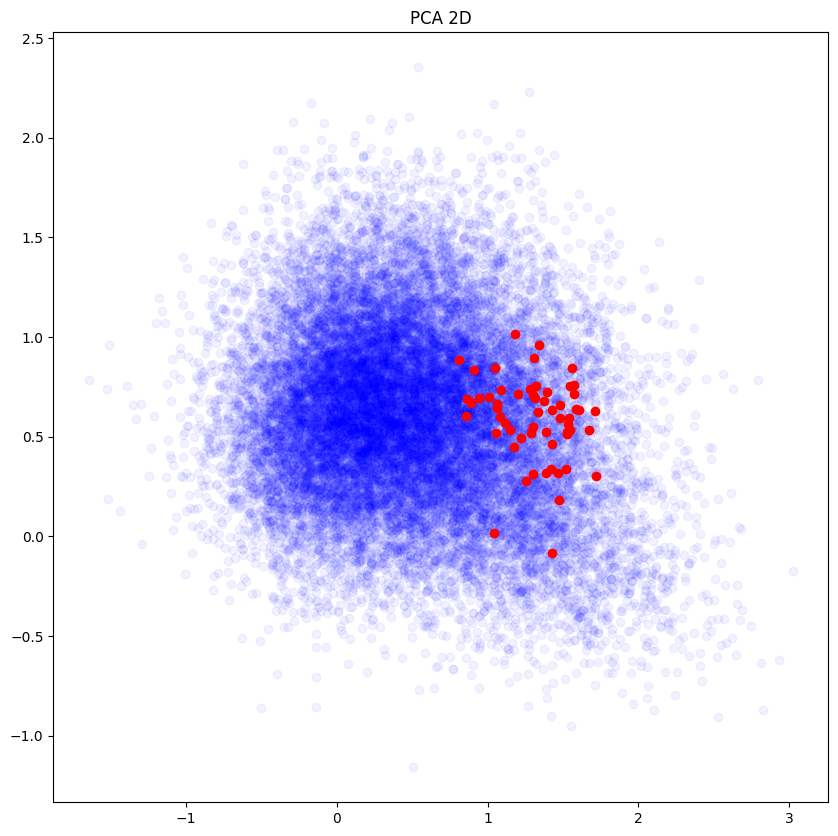

Counter({'Honda Civic': 16, 'Chevrolet': 8, 'Ford Mustang': 6, 'Chevrolet Corvette': 4, 'Toyota Prius': 3, 'Honda': 3, 'Volkswagen Passat': 3, 'Toyota': 3, 'Jaguar Cars': 1, 'Factory': 1, 'BMW': 1, 'Chevrolet Impala': 1, 'NASCAR': 1, 'Bentley': 1, 'Barbie': 1, 'Duramax V8 engine': 1, 'Ford Motor Company': 1, 'Lightning McQueen': 1, 'Hybrid vehicle': 1, 'Convertible': 1})


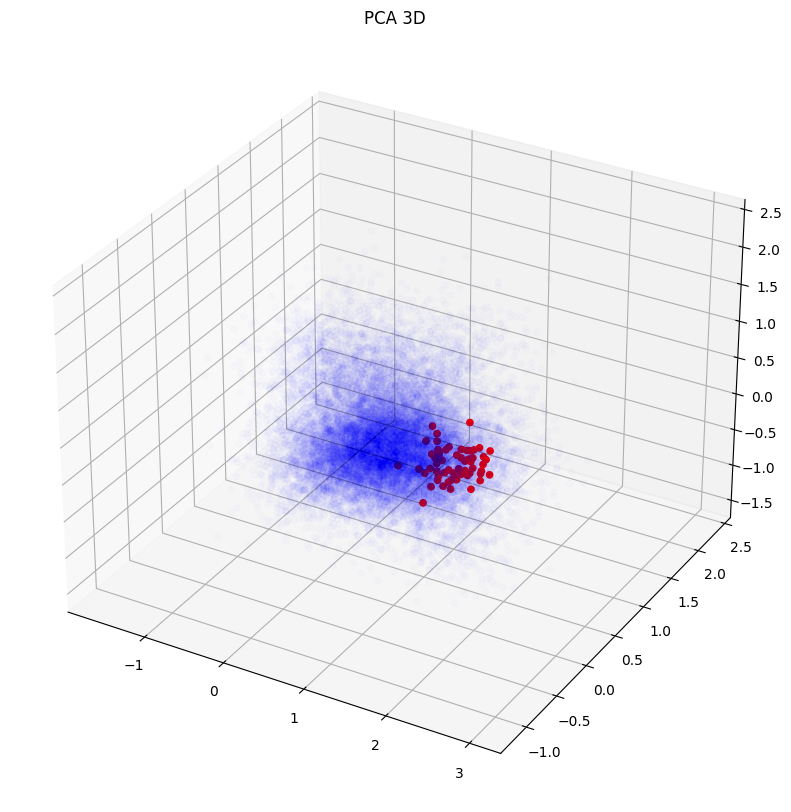

Counter({'Honda Civic': 16, 'Chevrolet': 8, 'Ford Mustang': 6, 'Chevrolet Corvette': 4, 'Toyota Prius': 3, 'Honda': 3, 'Volkswagen Passat': 3, 'Toyota': 3, 'Jaguar Cars': 1, 'Factory': 1, 'BMW': 1, 'Chevrolet Impala': 1, 'NASCAR': 1, 'Bentley': 1, 'Barbie': 1, 'Duramax V8 engine': 1, 'Ford Motor Company': 1, 'Lightning McQueen': 1, 'Hybrid vehicle': 1, 'Convertible': 1})


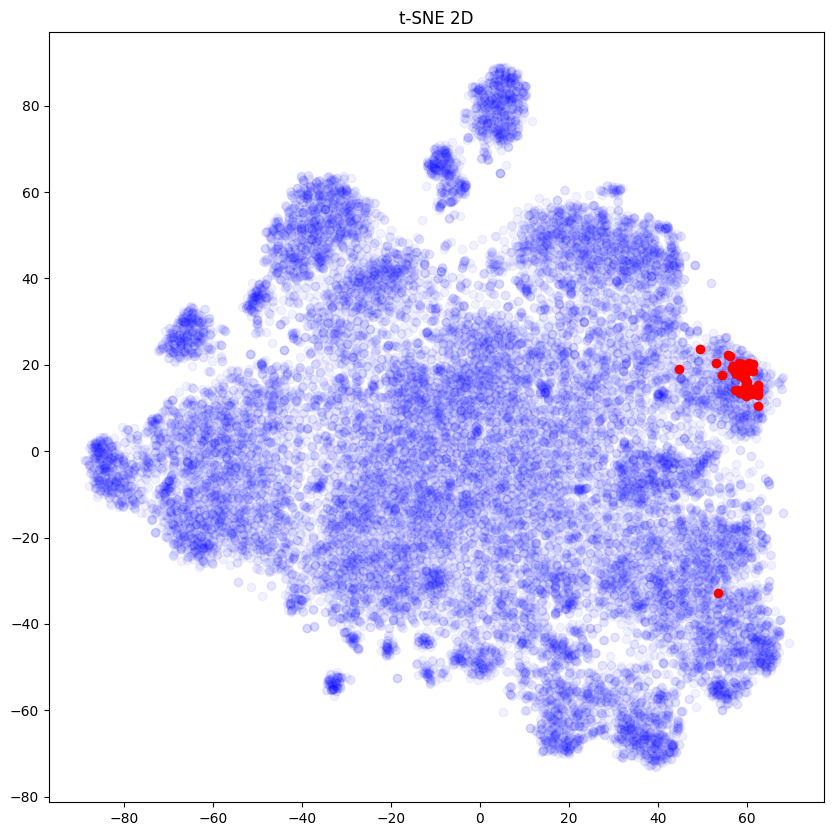

Counter({'Honda Civic': 16, 'Chevrolet': 8, 'Ford Mustang': 6, 'Chevrolet Corvette': 4, 'Toyota Prius': 3, 'Honda': 3, 'Volkswagen Passat': 3, 'Toyota': 3, 'Jaguar Cars': 1, 'Factory': 1, 'BMW': 1, 'Chevrolet Impala': 1, 'NASCAR': 1, 'Bentley': 1, 'Barbie': 1, 'Duramax V8 engine': 1, 'Ford Motor Company': 1, 'Lightning McQueen': 1, 'Hybrid vehicle': 1, 'Convertible': 1})


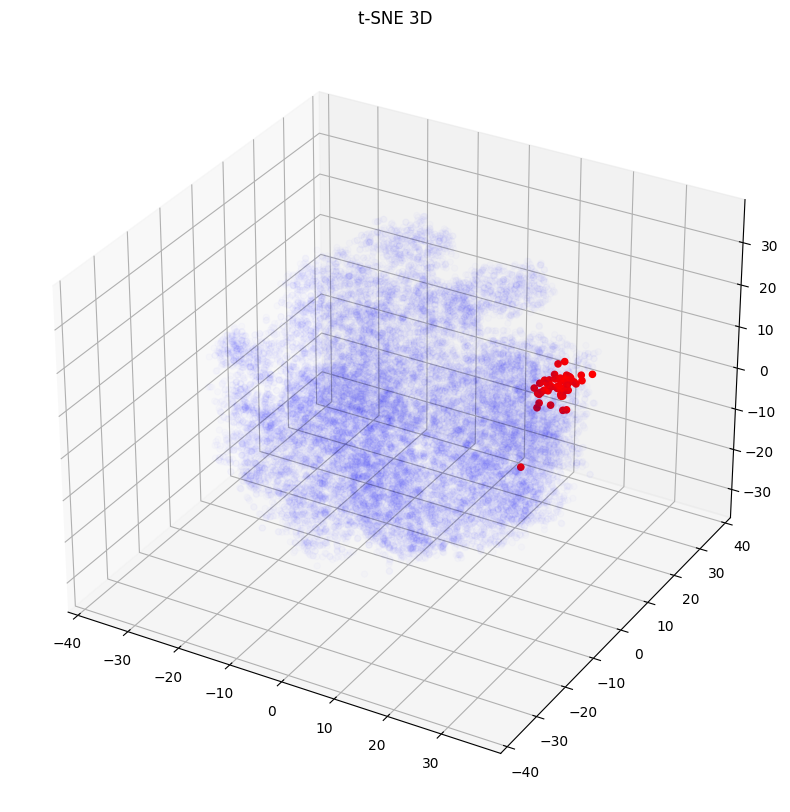

Counter({'Honda Civic': 16, 'Chevrolet': 8, 'Ford Mustang': 6, 'Chevrolet Corvette': 4, 'Toyota Prius': 3, 'Honda': 3, 'Volkswagen Passat': 3, 'Toyota': 3, 'Jaguar Cars': 1, 'Factory': 1, 'BMW': 1, 'Chevrolet Impala': 1, 'NASCAR': 1, 'Bentley': 1, 'Barbie': 1, 'Duramax V8 engine': 1, 'Ford Motor Company': 1, 'Lightning McQueen': 1, 'Hybrid vehicle': 1, 'Convertible': 1})


In [25]:
# Visualize the clusters, selecting one to plot in red
k = 300

# PCA 2D
visualize_cluster(dialogue_embeddings_pca_2d[cluster_labels == k], dialogue_embeddings_pca_2d[cluster_labels != k], dialogues, k, 'PCA 2D')

# PCA 3D
visualize_cluster(dialogue_embeddings_pca_3d[cluster_labels == k], dialogue_embeddings_pca_3d[cluster_labels != k], dialogues, k, 'PCA 3D')

# t-SNE 2D
visualize_cluster(dialogue_embeddings_tsne_2d[cluster_labels == k], dialogue_embeddings_tsne_2d[cluster_labels != k], dialogues, k, 't-SNE 2D')

# t-SNE 3D
visualize_cluster(dialogue_embeddings_tsne_3d[cluster_labels == k], dialogue_embeddings_tsne_3d[cluster_labels != k], dialogues, k, 't-SNE 3D')

### Sentence Embeddings

Instead of a Word2Vec followed by an average of the single word embeddings, let us now try a sentence embedding model and compare the results.

In [26]:
# Shape the data in a more useful way
parsed_data = [
    {
        'topic': sample['chosen_topic'],
        'dialogue': '\n'.join([utterance['text'] for utterance in sample['dialog']])
    }
for sample in data]
parsed_data = [(sample['topic'], sample['dialogue']) for sample in parsed_data]

In [27]:
# Create the sentence embedidng model
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [28]:
def encode(parsed_data=parsed_data, semb_model=semb_model):
    try:
        with open('dumps/sentence_embeddings.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        embeddings = [semb_model.encode(sample) for sample in parsed_data]
        with open('dumps/sentence_embeddings.pkl', 'wb') as f:
            pickle.dump(embeddings, f)
        return embeddings

In [29]:
# Get the sentence embeddings
embeddings = encode()

In [30]:
embeddings = np.array(embeddings).mean(axis=1)
embeddings.shape

(22311, 384)

Let's project the embeddings onto a 2D space:

In [31]:
# Project the embeddings using PCA
def get_pca_semb(n_components, embeddings):
    try:
        return pickle.load(open(f'./dumps/pca_semb_{n_components}.pkl', 'rb'))
    except:
        pca = PCA(n_components=n_components).fit(embeddings)
        pickle.dump(pca, open(f'./dumps/pca_semb_{n_components}.pkl', 'wb'))
        return pca

embeddings_2d = get_pca_semb(2, embeddings).transform(embeddings)
embeddings_3d = get_pca_semb(3, embeddings).transform(embeddings)

In [32]:
# Print out the topics
topics = list(set([sample[0] for sample in parsed_data]))

print('The topics are:')
print(topics)

print(f'\nThere are {len(topics)} topics.')

The topics are:
['U2', 'Koi', 'Hostage', 'Beadwork', 'Kayak', 'Carnivore', 'Green', 'Chalk', 'Young Frankenstein', 'Baton Rouge, Louisiana', 'Leather', 'Catholic school', 'Twilight (novel series)', 'Beard', 'Crystal healing', 'Intel 80386', 'Butterfly', 'Beauty pageant', 'Fairy tale', 'Gossip', 'Banana', 'Horse', 'Near-death experience', 'Game show', 'People for the Ethical Treatment of Animals', 'Stephen King', 'Unemployment', 'Puerto Rico', 'Asthma', 'Cancer', 'Healthy diet', 'Body piercing', "Children's literature", 'Smartphone', 'Kentucky', 'Chevrolet Tahoe', 'Rotisserie', 'Science fiction', 'Interior design', 'Chevrolet', 'The New Yorker', 'Mobile phone', 'Widow', 'Sports car', 'Eva Gutowski', 'Krav Maga', 'Graphic design', 'Salsa (dance)', 'American Society for the Prevention of Cruelty to Animals', 'Brie', 'Narcissism', 'Penguin Random House', 'Polyamory', 'Educational trail', 'Amazon Echo', 'Snare drum', 'Ultimate (sport)', 'Gummi candy', 'Juggling', 'Housewife', 'Golden Gate B

33 dialogues found for Depression (mood).


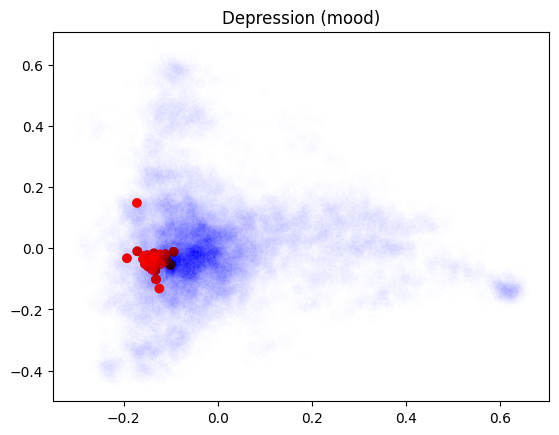

In [33]:
# Scatter the embeddings, highlight the chosen topic in red
topic = 'Depression (mood)'
n_dialogues = len([sample for sample in parsed_data if sample[0] == topic])
print(f'{n_dialogues} dialogues found for {topic}.')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=['r' if sample[0] == topic else 'b' for sample in parsed_data], alpha=[1 if sample[0] == topic else 0.005 for sample in parsed_data])
plt.title(topic)
plt.show()

That looks pretty good! Let's now try some K-Means clustering:

In [35]:
# Try unsupervised clustering
n_topics = len(set([sample[0] for sample in parsed_data]))
def cluster(embeddings=embeddings, n_clusters=100):
    try:
        with open(f'dumps/kmeans_semb_{n_clusters}.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(embeddings)
        with open(f'dumps/kmeans_semb_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        return kmeans
    
kmeans = cluster(n_clusters=400)

### Visualize a random cluster

In [36]:
print(dialogues[0])

{'topic': 'Science fiction', 'sentences_tokenized': [['i', 'think', 'science', 'fiction', 'is', 'an', 'amazing', 'genre', 'for', 'anything', 'future', 'science', 'technology', 'time', 'travel', 'ftl', 'travel', 'they', 're', 'all', 'such', 'interesting', 'concepts'], ['i', 'm', 'a', 'huge', 'fan', 'of', 'science', 'fiction', 'myself'], ['awesome', 'i', 'really', 'love', 'how', 'sci', 'fi', 'storytellers', 'focus', 'on', 'political', 'social', 'philosophical', 'issues', 'that', 'would', 'still', 'be', 'around', 'even', 'in', 'the', 'future', 'makes', 'them', 'relatable'], ['i', 'agree', 'one', 'of', 'my', 'favorite', 'forms', 'of', 'science', 'fiction', 'is', 'anything', 'related', 'to', 'time', 'travel', 'i', 'find', 'it', 'fascinating'], ['it', 's', 'not', 'quite', 'sci', 'fi', 'but', 'my', 'favorite', 'version', 'of', 'time', 'travel', 'is', 'in', 'harry', 'potter', 'and', 'the', 'prisoner', 'of', 'azkaban', 'breaks', 'zero', 'logical', 'rules'], ['and', 'that', 's', 'difficult', 'to

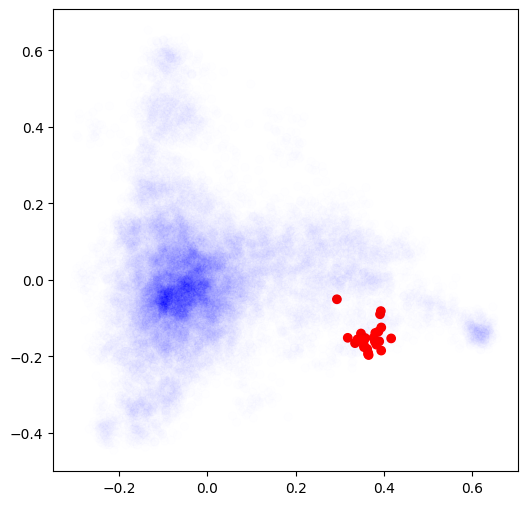

Counter({'Cheesecake': 23, 'The Cheesecake Factory': 3})


In [37]:
k = 150

# Scatter the embeddings, highlight the chosen cluster label k in red
plt.figure(figsize=(6, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=['r' if label == k else 'b' for label in kmeans.labels_], alpha=[1 if label == k else 0.005 for label in kmeans.labels_])
plt.show()

# Print the names of the topics in red
from nltk import Counter
topics = [sample[0] for i, sample in enumerate(parsed_data) if kmeans.labels_[i] == k]
print(Counter(topics))